In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle
import pqcd

from cmcrameri import cm
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d, PchipInterpolator
from matplotlib.colors import ListedColormap, to_hex
from pqcd.utils import (
    rcparams, 
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )
plt.rcParams.update(rcparams)

rng = np.random.default_rng()

In [3]:
collated_eos_path = '../data/eos-draws-default/collated_np_all_post.csv'
collated_eos = pd.read_csv(collated_eos_path)

collated_eos

,eos,logweight_total,Mmax,pressurec2(baryon_density=2.8e+14),pressurec2(baryon_density=5.6e+14),pressurec2(baryon_density=1.68e+15),energy_densityc2(baryon_density=2.8e+14),energy_densityc2(baryon_density=5.6e+14),energy_densityc2(baryon_density=1.68e+15),R(M=1.4),...,logweight_LVC_GW190425_PhenomPNRThi,Lambda(M=1.6),Lambda(M=1.8),R(M=2.2),Lambda(M=1.0),Lambda(M=1.2),Lambda(M=2.2),R(M=1.2),R(M=1.0),logweight_Fonseca_J0740
0,2265967.0,-inf,1.700984,3.139719e+12,4.073337e+13,4.278534e+14,2.842860e+14,5.828413e+14,2.064928e+15,11.985060,...,2.679168,165.095193,0.0,6.4988,2545.214606,955.596386,0.0,11.934217,11.866349,-inf
1,264698.0,-inf,1.590114,3.624216e+11,5.617729e+11,4.585547e+14,2.800613e+14,5.603871e+14,1.760666e+15,8.100073,...,2.795757,0.000000,0.0,6.4988,274.540682,106.508567,0.0,7.860560,7.545702,-inf
2,1683176.0,-inf,0.402205,5.612847e+12,6.763479e+12,8.613412e+12,2.775434e+14,5.602483e+14,1.689050e+15,4.130000,...,2.979787,0.000000,0.0,6.4988,0.000000,0.000000,0.0,3.544800,2.954000,-inf
3,696150.0,-inf,0.860414,2.399372e+12,5.710139e+12,2.346316e+14,2.844703e+14,5.727288e+14,1.770215e+15,4.130000,...,2.867603,0.000000,0.0,6.4988,0.000000,0.000000,0.0,3.544800,2.954000,-inf
4,275937.0,-inf,1.236473,2.442829e+11,1.612589e+12,1.701714e+14,2.741824e+14,5.488558e+14,1.725925e+15,4.130000,...,2.934103,0.000000,0.0,6.4988,121.700260,24.083029,0.0,7.045639,7.337356,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309536,280847.0,-inf,0.891053,3.731226e+12,4.280452e+12,5.440772e+12,2.910248e+14,5.842226e+14,1.754907e+15,4.130000,...,2.566539,0.000000,0.0,6.4988,0.000000,0.000000,0.0,3.544800,2.954000,-inf
309537,459317.0,-inf,0.590972,3.362687e+12,4.641949e+12,9.133094e+13,2.611666e+14,5.258588e+14,1.641949e+15,4.130000,...,2.992270,0.000000,0.0,6.4988,0.000000,0.000000,0.0,3.544800,2.954000,-inf
309538,2234499.0,-inf,1.665527,3.890397e+12,4.155894e+13,3.725335e+14,2.836612e+14,5.811064e+14,2.049550e+15,12.147656,...,2.599360,115.083765,0.0,6.4988,2736.187795,1026.861257,0.0,12.390059,12.365665,-inf
309539,2285403.0,-inf,1.415895,1.298773e+12,9.396924e+12,3.111593e+14,2.825170e+14,5.678329e+14,1.811870e+15,7.935074,...,3.062617,0.000000,0.0,6.4988,278.655784,87.238253,0.0,8.280072,8.295072,-inf


# pQCD posterior

In [4]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

muH = 2.6
mu_array = np.linspace(muL, muH, 1000)

### KDE on EOS extensions

In [5]:
xlim = (0.13471795348380078, 17.002209254489188)
ylim = (0.0014798402249155988, 6.262273589369166)

In [6]:
# Define the number of colors in the colormap
ncolors = 256

# Create an array for RGBA values
colors = np.zeros((ncolors, 4))

# Set RGB values to 0 (black)
colors[:, 0] = 0  # Red channel
colors[:, 1] = 0  # Green channel
colors[:, 2] = 0  # Blue channel

# Set alpha values to transition from 0 (transparent) to 1 (opaque)
colors[:, 3] = np.linspace(0, 1, ncolors)

# Create the custom colormap
transparent_to_black = ListedColormap(colors, name='TransparentToBlack')

In [7]:
# EOS extension KDE

n0 = 10*nsat

with open(
    '../data/eos-extensions/eos_extensions_'
    's-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 
    'rb'
    ) as f:
    eos_extensions = pickle.load(f)

eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

e_kde = []
p_kde = []
for index, eos in eos_extensions.iterrows():
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    e_kde.append(eos.e[highlight_index])
    p_kde.append(eos.p[highlight_index])

e_kde = np.array(e_kde)
p_kde = np.array(p_kde)

# Stack the data into a 2D array
data = np.vstack([e_kde, p_kde])

# Create the KDE
kde = gaussian_kde(data)

# Generate a grid over which to evaluate the KDE
x_min, x_max = xlim[0], xlim[1]
y_min, y_max = ylim[0], ylim[1]
X, Y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

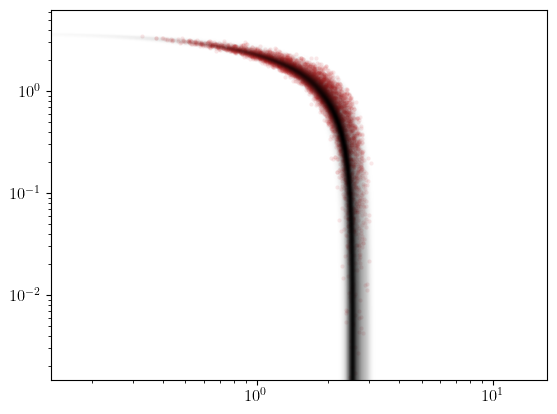

In [8]:
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_kde, p_kde, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.1)
ax.imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=2,
    alpha=1
);

In [9]:
e_10nsat = np.loadtxt('../data/eos-draws-default/quantities_at_n/energy_density_10nsat.dat')
p_10nsat = np.loadtxt('../data/eos-draws-default/quantities_at_n/pressure_10nsat.dat')

mask = ~np.logical_or(np.isnan(e_10nsat), np.isnan(p_10nsat))
e_10nsat = e_10nsat[mask]
p_10nsat = p_10nsat[mask]

sample = rng.choice(len(e_10nsat), size=10000, replace=False)
e_10nsat = e_10nsat[sample]
p_10nsat = p_10nsat[sample]

### Inspect EOS prior at $10n_\mathrm{sat}$

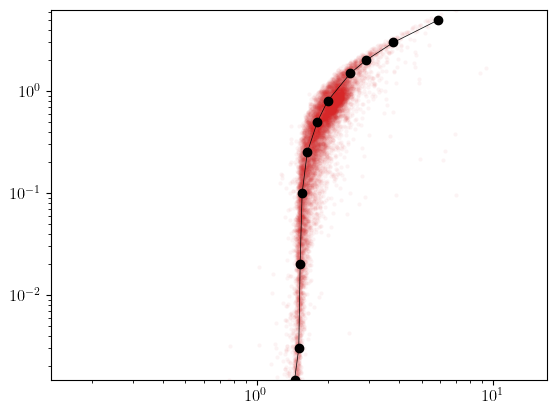

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_10nsat, p_10nsat, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.05)

x_fit = [1.45, 1.51, 1.53, 1.56, 1.64, 1.81, 2.0, 2.5, 2.9, 3.8, 5.9]
y_fit = [ylim[0], 3e-3, 2e-2, 1e-1, 2.5e-1, 5e-1, 8e-1, 1.5, 2, 3, 5]
ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='k');

In [11]:
x_fit_dense_10nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_10nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_10nsat)

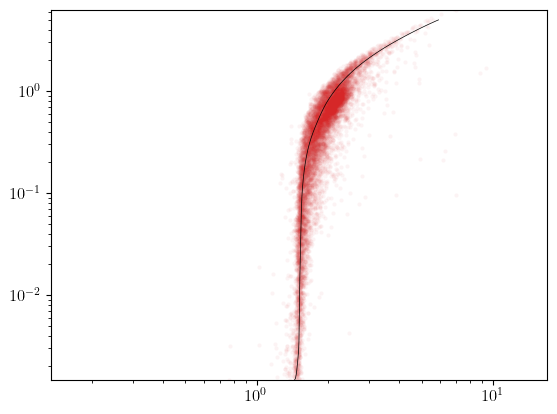

In [12]:
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(e_10nsat, p_10nsat, lw=0, marker='.', markeredgewidth=0, c='C3', alpha=0.05)
ax.plot(x_fit_dense_10nsat, y_fit_dense_10nsat, lw=0.5, c='k');

In [13]:
def plot_quantiles(ax, quantiles, x_pe, c, ls, lw, x_cut, y_cut, 
                   fill_alpha=0.25, alpha_scale=0.25, line_zorder=1.2, 
                   fill_zorder=0.8):

    y_fit_interp = np.interp(x_pe, x_cut, y_cut, left=-100)

    q5 = quantiles.loc[5,:].values
    q95 = quantiles.loc[95,:].values

    i1 = np.argmin((q5 - y_fit_interp)**2)
    i2 = np.argmin((q95 - y_fit_interp)**2)

    # Full opacity

    ax.fill_between(
        x_pe[:i1], 
        q5[:i1], 
        q95[:i1], 
        color=list(c)[:3]+[fill_alpha], 
        edgecolor=c,
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[:i1],
        q5[:i1],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    ax.plot(
        x_pe[:i1],
        q95[:i1],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    # Intermediate upper

    ax.fill_between(
        x_pe[i1-1:i2], 
        y_fit_interp[i1-1:i2], 
        q95[i1-1:i2], 
        color=list(c)[:3] + [fill_alpha], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i1:i2],
        q95[i1:i2],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder
    )

    # Intermediate lower

    ax.fill_between(
        x_pe[i1-1:i2], 
        q5[i1-1:i2], 
        y_fit_interp[i1-1:i2],
        color=list(c)[:3] + [fill_alpha*alpha_scale], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i1:i2],
        q5[i1:i2],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

    # Low opacity

    ax.fill_between(
        x_pe[i2:], 
        q5[i2:], 
        q95[i2:], 
        color=list(c)[:3] + [fill_alpha*alpha_scale], 
        linewidth=0,
        zorder=fill_zorder,
        )

    ax.plot(
        x_pe[i2:],
        q5[i2:],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

    ax.plot(
        x_pe[i2:],
        q95[i2:],
        lw=lw,
        linestyle=ls,
        c=c,
        zorder=line_zorder,
        alpha=alpha_scale
    )

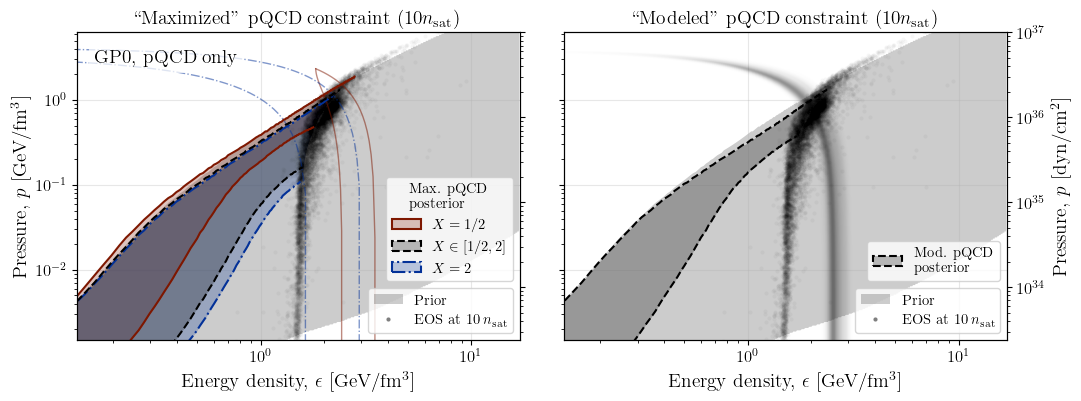

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# pQCD likelihood
# ---------------

X_list = [0.5, 2]
c_list = [cm.roma(0.), cm.roma(1.)]
ls_list = ['-', '-.']

# Maximized

for i, X in enumerate(X_list):

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)

    mu0 = np.linspace((n0/nH)*muH, muH, num=100)

    p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
    epsilon0_min = mu0*n0 - p0_min

    p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
    epsilon0_max = mu0*n0 - p0_max

    alpha = 0.5
    ls = ls_list[i]
    c = c_list[i]
    zorder = 1
    lw = 1

    if X == 0.5:
        axs[0].plot(
            epsilon0_min, 
            p0_min, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )
        axs[0].plot(
            epsilon0_max, 
            p0_max, 
            c=c,
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )

    if X == 2:
        axs[0].plot(
            epsilon0_min, 
            p0_min, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )
        axs[0].plot(
            epsilon0_max, 
            p0_max, 
            c=c, 
            alpha=alpha, 
            ls=ls, 
            zorder=zorder, 
            lw=lw
        )

# Marginalized

axs[1].imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=1,
    alpha=0.5
)

# GP posteriors
# -------------

# Max

lw = 1.5

for i, X in enumerate(X_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_X{X}_mu2.6.csv')
    )

    plot_quantiles(
        axs[0], 
        quantiles,
        x_pe,
        c=c_list[i],
        ls=ls_list[i],
        lw=lw,
        x_cut=x_fit_dense_10nsat,
        y_cut=y_fit_dense_10nsat,
        alpha_scale=0
    )
    
quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_Xmarg_mu2.6.csv')
)

plot_quantiles(
    axs[0], 
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dense_10nsat,
    y_cut=y_fit_dense_10nsat,
    alpha_scale=0
)

# Marg

# c = cm.lipari(0.4)
c = [0,0,0]

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_marg.csv')
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dense_10nsat,
    y_cut=y_fit_dense_10nsat,
    alpha_scale=0
)

# GP prior at 10nsat
# ------------------

for ax in axs:
    ax.plot(
        e_10nsat, 
        p_10nsat, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.03, 
        markeredgewidth=0,
        zorder=0.9,
        rasterized=True
    )

# ---

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_list[0])[:3]+[0.25],
        edgecolor=c_list[0],
        lw=1.5,
        linestyle=ls_list[0]
    ),
    mpatches.Patch(
        facecolor=[0,0,0,0.25], 
        edgecolor='k', 
        fill=True, 
        lw=1.5, 
        linestyle='--'
    ),
    mpatches.Patch(
        facecolor=list(c_list[1])[:3]+[0.25],
        edgecolor=c_list[1],
        lw=1.5,
        linestyle=ls_list[1]
    ),
]

custom_labels = [
    '$X = 1/2$',
    '$X \in [1/2,2]$',
    '$X = 2$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='Max. pQCD\nposterior', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.17))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(
        facecolor=[0,0,0,0.25], 
        edgecolor='k', 
        fill=True, 
        lw=1.5, 
        linestyle='--')
]

custom_labels = [
    'Mod. pQCD\nposterior'
]

l2 = axs[1].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    fontsize=10.5,
    bbox_to_anchor=(1,0.17)
)

axs[1].add_artist(l2)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Prior',
    'EOS at $10\,n_\mathrm{sat}$',
]

for ax in axs:
    ax.legend(
        custom_handles,
        custom_labels,
        loc='lower right',
        fontsize=10.5
    )

# ---

axs[0].text(
    0.04, 
    0.9, 
    'GP0, pQCD only', 
    transform=axs[0].transAxes,
    # add background
    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none')
)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($10n_\mathrm{sat}$)')
axs[1].set_title('``Modeled" pQCD constraint ($10n_\mathrm{sat}$)')

fig.savefig('figures/paper/pqcd_e_p_posterior_10nsat.pdf', bbox_inches='tight', dpi=300)

In [15]:
ntov = to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])

ntov_mask = (
    (ntov > 1.5*nsat) &
    (ntov < 12*nsat)
)

e_tov = np.loadtxt(
    f'../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)

p_tov = np.loadtxt(
    f'../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)

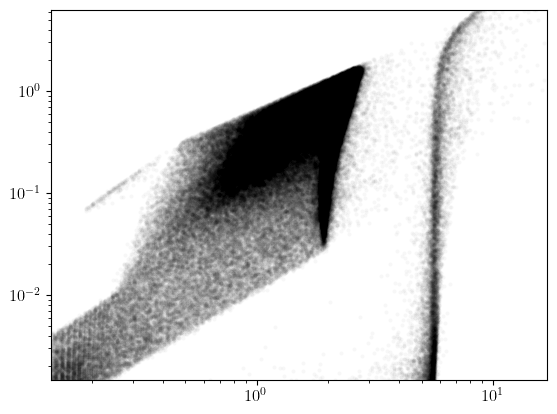

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(
    e_tov, 
    p_tov, 
    lw=0, 
    marker='.', 
    markeredgewidth=0, 
    c='k', 
    alpha=0.03
);

In [17]:
nterm_list = [4,6,8]

e_nterm_dict = {}
p_nterm_dict = {}

for nterm in nterm_list:

    e_nterm = np.loadtxt(
        f'../data/eos-draws-default/quantities_at_n/energy_density_{nterm:02}nsat.dat'
    )
    p_nterm = np.loadtxt(
        f'../data/eos-draws-default/quantities_at_n/pressure_{nterm:02}nsat.dat'
    )

    mask = ~np.logical_or(np.isnan(e_nterm), np.isnan(p_nterm))
    e_nterm = e_nterm[mask]
    p_nterm = p_nterm[mask]

    sample = rng.choice(len(e_nterm), size=10000, replace=False)
    e_nterm = e_nterm[sample]
    p_nterm = p_nterm[sample]

    e_nterm_dict[nterm] = e_nterm
    p_nterm_dict[nterm] = p_nterm

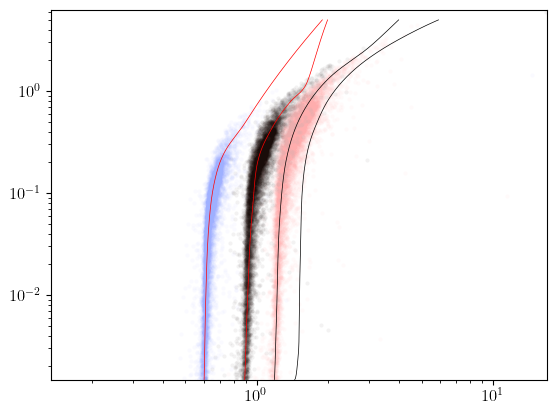

In [18]:
c_dict = {
    nterm: cm.berlin(i/(len(nterm_list)-1)) for i, nterm in enumerate(nterm_list)
}

fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xscale('log')
ax.set_yscale('log')

# ax.plot(
#     e_tov, 
#     p_tov, 
#     lw=0, 
#     marker='.', 
#     markeredgewidth=0, 
#     c='red', 
#     alpha=0.03
# )

for i, nterm in enumerate(nterm_list):

    c = c_dict[nterm]

    ax.plot(
        e_nterm_dict[nterm], 
        p_nterm_dict[nterm], 
        lw=0, 
        marker='.', 
        markeredgewidth=0, 
        c=c, 
        alpha=0.05
    )

# 8nsat
x_fit = [1.19, 1.215, 1.25, 1.33, 1.5, 2, 3, 4]
y_fit = [ylim[0], 0.006, 0.05, 0.2, 0.5, 1.3, 2.7, 5]
x_fit_dense_8nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_8nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_8nsat)

# 6nsat
x_fit = [0.89, 0.91, 0.95, 1.01, 1.14, 1.4, 1.6, 2]
y_fit = [ylim[0], 0.006, 0.05, 0.2, 0.4, 0.8, 1.1, 5]
x_fit_dense_6nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_6nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_6nsat)

# 4nsat
x_fit = [0.6, 0.61, 0.62, 0.65, 0.7, 0.9, 1.9]
y_fit = [ylim[0], 0.01, 0.03, 0.1, 0.2, 0.5, 5]
x_fit_dense_4nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_4nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_4nsat)

# ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='r')

ax.plot(x_fit_dense_4nsat, y_fit_dense_4nsat, lw=0.5, c='r')
ax.plot(x_fit_dense_6nsat, y_fit_dense_6nsat, lw=0.5, c='r')
ax.plot(x_fit_dense_8nsat, y_fit_dense_8nsat, lw=0.5, c='k')
ax.plot(x_fit_dense_10nsat, y_fit_dense_10nsat, lw=0.5, c='k')

x_fit_dict = {
    4: x_fit_dense_4nsat,
    6: x_fit_dense_6nsat,
    8: x_fit_dense_8nsat,
    10: x_fit_dense_10nsat
}

y_fit_dict = {
    4: y_fit_dense_4nsat,
    6: y_fit_dense_6nsat,
    8: y_fit_dense_8nsat,
    10: y_fit_dense_10nsat
}

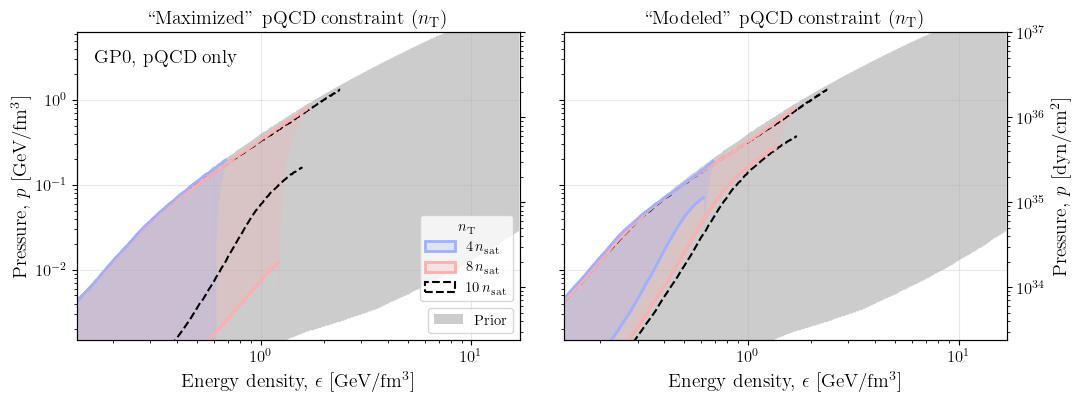

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 2

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 8,
    8: 7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv')
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(nterm):02}nsat_marg.csv')
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_Xmarg_mu2.6.csv')
)

plot_quantiles(
    axs[0],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=1.5,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

# ---

# quantiles = to_GeV_per_cubic_femtometre(
#     pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_Xmarg_mu2.6.csv')
# )

# q5 = quantiles.loc[5,:].values
# q95 = quantiles.loc[95,:].values

# axs[0].plot(x_pe, q5, c='k', ls=':')
# axs[0].plot(x_pe, q95, c='k', ls=':')

# quantiles = to_GeV_per_cubic_femtometre(
#     pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_marg.csv')
# )

# q5 = quantiles.loc[5,:].values
# q95 = quantiles.loc[95,:].values

# axs[1].plot(x_pe, q5, c='k', ls=':')
# axs[1].plot(x_pe, q95, c='k', ls=':')

# ---

# for i, nterm in enumerate([4,8]):

#     c = c_dict[nterm]

#     for ax in axs:
#         ax.plot(
#             e_nterm_dict[nterm], 
#             p_nterm_dict[nterm], 
#             lw=0, 
#             marker='.', 
#             markeredgewidth=0, 
#             c=c, 
#             alpha=0.03,
#             zorder=0.2
#         )

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=2,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4\,n_\mathrm{sat}$',
    '$8\,n_\mathrm{sat}$',
    '$10\,n_\mathrm{sat}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{T}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.105))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
]

custom_labels = [
    'Prior',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(0.04, 0.9, 'GP0, pQCD only', transform=axs[0].transAxes)

# ---

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD constraint ($n_\mathrm{T}$)')
axs[1].set_title('``Modeled" pQCD constraint ($n_\mathrm{T}$)')

fig.savefig('figures/paper/pqcd_e_p_posterior_nterm.pdf', bbox_inches='tight', dpi=300)

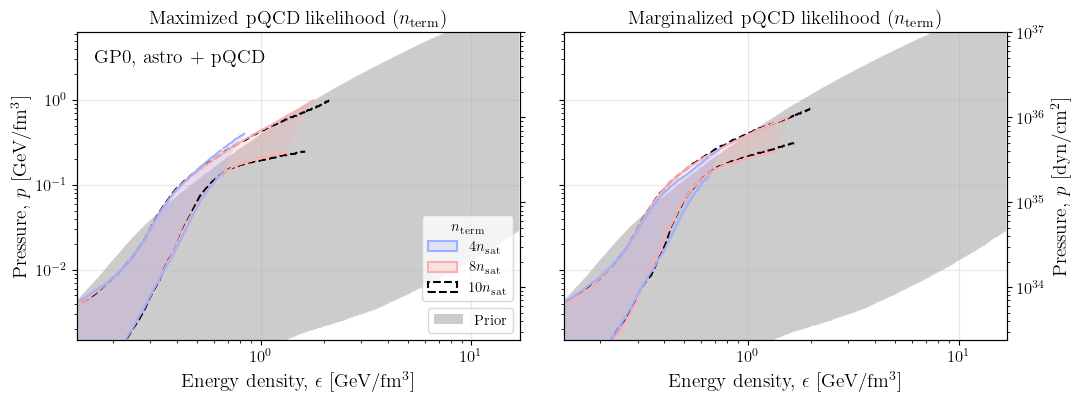

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# GP prior
# --------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# GP posteriors
# -------------

lw = 1.5

line_zorder_dict = {
    4: 10,
    8: 9
}

fill_zorder_dict = {
    4: 8,
    8: 7
}

for i, nterm in enumerate([4,8]):

    c = c_dict[nterm]

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_{int(nterm):02}nsat_Xmarg_mu2.6.csv')
    )

    plot_quantiles(
        axs[0],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_{int(nterm):02}nsat_marg.csv')
    )

    plot_quantiles(
        axs[1],
        quantiles,
        x_pe,
        c=c,
        ls='-',
        lw=lw,
        x_cut=x_fit_dict[nterm],
        y_cut=y_fit_dict[nterm],
        alpha_scale=0,
        fill_alpha=0.25,
        line_zorder=line_zorder_dict[nterm],
        fill_zorder=fill_zorder_dict[nterm]
    )

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_Xmarg_mu2.6.csv')
)

plot_quantiles(
    axs[0],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_marg.csv')
)

plot_quantiles(
    axs[1],
    quantiles,
    x_pe,
    c=[0,0,0],
    ls='--',
    lw=lw,
    x_cut=x_fit_dict[10],
    y_cut=y_fit_dict[10],
    alpha_scale=0,
    fill_alpha=0,
    line_zorder=8.1,
    fill_zorder=2
)

# ---

# for i, nterm in enumerate([4,8]):

#     c = c_dict[nterm]

#     for ax in axs:
#         ax.plot(
#             e_nterm_dict[nterm], 
#             p_nterm_dict[nterm], 
#             lw=0, 
#             marker='.', 
#             markeredgewidth=0, 
#             c=c, 
#             alpha=0.03,
#             zorder=0.2
#         )

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_dict[nterm])[:3]+[0.25],
        edgecolor=c_dict[nterm],
        lw=1.5,
        linestyle='-'
    )
    for nterm in [4,8]
]

custom_handles.append(
    mpatches.Patch(
        facecolor=[0,0,0,0.0],
        edgecolor=[0,0,0,1],
        lw=1.5,
        linestyle='--'
    )
)

custom_labels = [
    '$4n_\mathrm{sat}$',
    '$8n_\mathrm{sat}$',
    '$10n_\mathrm{sat}$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='$n_\mathrm{term}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.105))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
]

custom_labels = [
    'Prior',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

# ---

axs[0].text(0.04, 0.9, 'GP0, astro + pQCD', transform=axs[0].transAxes)

# ---

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('Maximized pQCD likelihood ($n_\mathrm{term}$)')
axs[1].set_title('Marginalized pQCD likelihood ($n_\mathrm{term}$)')

fig.savefig('figures/paper/astro_pqcd_e_p_posterior_nterm.pdf', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots()

ax.hist(to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])/nsat, bins=100)

collated_eos_mass_cut = collated_eos[collated_eos['logweight_Antoniadis_J0348'] > -np.inf]
ax.hist(to_nucleons_per_cubic_femtometre(collated_eos_mass_cut['rhoc(M@Mmax)'])/nsat, bins=100, histtype='step');

collated_eos_nonzero_astro = collated_eos[collated_eos['logweight_total'] > -np.inf]
ax.hist(to_nucleons_per_cubic_femtometre(collated_eos_nonzero_astro['rhoc(M@Mmax)'])/nsat, bins=100);

In [ ]:
e_ntov = np.loadtxt('../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat')
p_ntov = np.loadtxt('../data/eos-draws-default/quantities_at_n/pressure_ntov.dat')

In [ ]:
len(e_ntov), len(p_ntov)

In [ ]:
len(collated_eos)

In [ ]:
e_ntov = e_ntov[collated_eos.logweight_total > -np.inf]
p_ntov = p_ntov[collated_eos.logweight_total > -np.inf]

In [ ]:
mask = ~np.logical_or(np.isnan(e_ntov), np.isnan(p_ntov))

e_ntov = e_ntov[mask]
p_ntov = p_ntov[mask]

In [ ]:
len(e_ntov), len(p_ntov)

In [ ]:
sample = rng.choice(len(e_ntov), size=10000, replace=False)

e_ntov = e_ntov[sample]
p_ntov = p_ntov[sample]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

# GP prior
# --------

prior_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))
prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        prior_x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# pQCD likelihood
# ---------------

X_list = [0.5, 2]
c_list = [cm.roma(0.), cm.roma(1.)]

# GP posteriors
# -------------

# Max

zorder_dict = {
    0.5: 2,
    2: 1.5
}

lw = 1.5

for i, X in enumerate(X_list):

    pqcd_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_X{X}_mu2.6.csv')
    )

    q5 = quantiles.loc[5,:].values
    q95 = quantiles.loc[95,:].values

    # Full opacity

    axs[0].fill_between(
        pqcd_x_pe, 
        q5, 
        q95, 
        color=list(c_list[i])[:3]+[0.25], 
        edgecolor=c_list[i],
        linewidth=0,
        linestyle='-',
        zorder=0.8,
        )

    axs[0].plot(
        pqcd_x_pe,
        q5,
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2
    )

    axs[0].plot(
        pqcd_x_pe,
        q95,
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2
    )
    
quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_Xmarg_mu2.6.csv')
)

q5 = quantiles.loc[5,:].values
q95 = quantiles.loc[95,:].values

# Full opacity

axs[0].fill_between(
    pqcd_x_pe, 
    q5, 
    q95, 
    color=[0,0,0] + [0.25], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[0].plot(
    pqcd_x_pe,
    q5,
    lw=lw,
    linestyle='--',
    c='k',
    zorder=1.2
)

axs[0].plot(
    pqcd_x_pe,
    q95,
    lw=lw,
    linestyle='--',
    c='k',
    zorder=1.2
)

# Marg

# c = cm.lipari(0.4)
c = [0,0,0]

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_marg.csv')
)

q5 = quantiles.loc[5,:].values
q95 = quantiles.loc[95,:].values

# Full opacity

axs[1].fill_between(
    pqcd_x_pe, 
    q5, 
    q95, 
    color=list(c)[:3] + [0.25], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[1].plot(
    pqcd_x_pe,
    q5,
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2
)

axs[1].plot(
    pqcd_x_pe,
    q95,
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2
)

# GP prior at 10nsat
# ------------------

for ax in axs:
    ax.plot(
        e_ntov, 
        p_ntov, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.03, 
        markeredgewidth=0,
        zorder=0.9
    )

# ---

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_list[0])[:3]+[0.25],
        edgecolor=c_list[0],
        lw=1.5
    ),
    mpatches.Patch(facecolor=[0,0,0,0.25], edgecolor='k', fill=True, lw=1.5, linestyle='--'),
    mpatches.Patch(
        facecolor=list(c_list[1])[:3]+[0.25],
        edgecolor=c_list[1],
        lw=1.5
    ),
]

custom_labels = [
    '$X = 1/2$',
    '$X \in [1/2,2]$',
    '$X = 2$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='Max. pQCD\nposterior', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.17))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Prior',
    'EOS at $n_\mathrm{TOV}$',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

custom_handles = [
    mpatches.Patch(facecolor=[0,0,0,0.25], edgecolor='k', fill=True, lw=1.5, linestyle='--')
]

custom_labels = [
    'Marg. pQCD\nposterior'
]

axs[1].legend(custom_handles, custom_labels, loc='lower right', fontsize=10.5) #  handlelength=0.7

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('Maximized pQCD likelihood')
axs[1].set_title('Marginalized pQCD likelihood')

fig.savefig('figures/paper/pqcd_posterior_ntov.pdf', bbox_inches='tight')

In [ ]:
len(collated_eos)

In [ ]:
len(e_ntov)

In [ ]:
n0 = 6*nsat

# EOS extension KDE

with open(
    '../data/eos-extensions/eos_extensions_'
    's-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 
    'rb'
    ) as f:
    eos_extensions = pickle.load(f)

eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

e_kde = []
p_kde = []
for index, eos in eos_extensions.iterrows():
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    e_kde.append(eos.e[highlight_index])
    p_kde.append(eos.p[highlight_index])

e_kde = np.array(e_kde)
p_kde = np.array(p_kde)

# Stack the data into a 2D array
data = np.vstack([e_kde, p_kde])

# Create the KDE
kde = gaussian_kde(data)

# Generate a grid over which to evaluate the KDE
x_min, x_max = xlim[0], xlim[1]
y_min, y_max = ylim[0], ylim[1]
X, Y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

In [ ]:
e_kde = np.loadtxt('../data/eos-draws-default/quantities_at_n/energy_density_06nsat.dat')
p_kde = np.loadtxt('../data/eos-draws-default/quantities_at_n/pressure_06nsat.dat')

mask = ~np.logical_or(np.isnan(e_kde), np.isnan(p_kde))

e_kde = e_kde[mask]
p_kde = p_kde[mask]

sample = rng.choice(len(e_kde), size=10000, replace=False)

e_kde = e_kde[sample]
p_kde = p_kde[sample]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')

# GP prior
# --------

prior_x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

for ax in axs:
    ax.fill_between(
        prior_x_pe,
        prior_quantiles_pe.loc[5,:].values,
        prior_quantiles_pe.loc[95,:].values,
        color='k',
        alpha=0.2,
        linewidth=0,
        label='Prior',
        zorder=0.1
    )

# pQCD likelihood
# ---------------

X_list = [0.5, 2]
c_list = [cm.roma(0.), cm.roma(1.)]

# Maximized

for i, X in enumerate(X_list):

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)

    mu0 = np.linspace((n0/nH)*muH, muH, num=1000)

    p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
    epsilon0_min = mu0*n0 - p0_min

    p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
    epsilon0_max = mu0*n0 - p0_max

    alpha = 0.5
    ls = '-'
    zorder = 1
    lw = 1

    if X == 0.5:
        axs[0].plot(epsilon0_min, p0_min, c=cm.roma(0.0), alpha=alpha, ls=ls, zorder=zorder, lw=lw)
        axs[0].plot(epsilon0_max, p0_max, c=cm.roma(0.0), alpha=alpha, ls=ls, zorder=zorder, lw=lw)

    if X == 2:
        axs[0].plot(epsilon0_min, p0_min, c=cm.roma(1.0), alpha=alpha, ls=ls, zorder=zorder, lw=lw)
        axs[0].plot(epsilon0_max, p0_max, c=cm.roma(1.0), alpha=alpha, ls=ls, zorder=zorder, lw=lw)

# Marginalized

axs[1].imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=1,
    alpha=0.5
)

# GP posteriors
# -------------

# Max

zorder_dict = {
    0.5: 2,
    2: 1.5
}

lw = 1.5

for i, X in enumerate(X_list):

    pqcd_x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
    y_fit_interp = np.interp(pqcd_x_pe, x_fit_dense, y_fit_dense, left=-100)

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_X{X}_mu2.6.csv')
    )

    q5 = quantiles.loc[5,:].values
    q95 = quantiles.loc[95,:].values

    i1 = np.argmin((q5 - y_fit_interp)**2)
    i2 = np.argmin((q95 - y_fit_interp)**2)

    # Full opacity

    axs[0].fill_between(
        pqcd_x_pe[:i1], 
        q5[:i1], 
        q95[:i1], 
        color=list(c_list[i])[:3]+[0.25], 
        edgecolor=c_list[i],
        linewidth=0,
        linestyle='-',
        zorder=0.8,
        )

    axs[0].plot(
        pqcd_x_pe[:i1],
        q5[:i1],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2
    )

    axs[0].plot(
        pqcd_x_pe[:i1],
        q95[:i1],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2
    )

    # Intermediate upper

    axs[0].fill_between(
        pqcd_x_pe[i1-1:i2], 
        y_fit_interp[i1-1:i2], 
        q95[i1-1:i2], 
        color=list(c_list[i])[:3] + [0.25], 
        linewidth=0,
        linestyle='-',
        zorder=0.8,
        )

    axs[0].plot(
        pqcd_x_pe[i1:i2],
        q95[i1:i2],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2
    )

    # Intermediate lower

    alpha_scale = 0.25

    axs[0].fill_between(
        pqcd_x_pe[i1-1:i2], 
        q5[i1-1:i2], 
        y_fit_interp[i1-1:i2],
        color=list(c_list[i])[:3] + [0.25*alpha_scale], 
        linewidth=0,
        linestyle='-',
        zorder=0.8,
        )

    axs[0].plot(
        pqcd_x_pe[i1:i2],
        q5[i1:i2],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2,
        alpha=alpha_scale
    )

    # Low opacity

    axs[0].fill_between(
        pqcd_x_pe[i2:], 
        q5[i2:], 
        q95[i2:], 
        color=list(c_list[i])[:3] + [0.25*alpha_scale], 
        linewidth=0,
        linestyle='-',
        zorder=0.8,
        )

    axs[0].plot(
        pqcd_x_pe[i2:],
        q5[i2:],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2,
        alpha=alpha_scale
    )

    axs[0].plot(
        pqcd_x_pe[i2:],
        q95[i2:],
        lw=lw,
        linestyle='-',
        c=c_list[i],
        zorder=1.2,
        alpha=alpha_scale
    )
    
# quantiles = to_GeV_per_cubic_femtometre(
#     pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_Xmarg_mu2.6.csv')
# )

# q5 = quantiles.loc[5,:].values
# q95 = quantiles.loc[95,:].values

# i1 = np.argmin((q5 - y_fit_interp)**2)
# i2 = np.argmin((q95 - y_fit_interp)**2)

# # Full opacity

# axs[0].fill_between(
#     pqcd_x_pe[:i1], 
#     q5[:i1], 
#     q95[:i1], 
#     color=[0,0,0] + [0.25], 
#     linewidth=0,
#     linestyle='-',
#     zorder=0.8,
#     )

# axs[0].plot(
#     pqcd_x_pe[:i1],
#     q5[:i1],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2
# )

# axs[0].plot(
#     pqcd_x_pe[:i1],
#     q95[:i1],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2
# )

# # Intermediate upper

# axs[0].fill_between(
#     pqcd_x_pe[i1-1:i2], 
#     y_fit_interp[i1-1:i2], 
#     q95[i1-1:i2], 
#     color=[0,0,0] + [0.25], 
#     linewidth=0,
#     linestyle='-',
#     zorder=0.8,
#     )

# axs[0].plot(
#     pqcd_x_pe[i1:i2],
#     q95[i1:i2],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2
# )

# # Intermediate lower

# alpha_scale = 0.25

# axs[0].fill_between(
#     pqcd_x_pe[i1-1:i2], 
#     q5[i1-1:i2], 
#     y_fit_interp[i1-1:i2],
#     color=[0,0,0] + [0.25*alpha_scale], 
#     linewidth=0,
#     linestyle='-',
#     zorder=0.8,
#     )

# axs[0].plot(
#     pqcd_x_pe[i1:i2],
#     q5[i1:i2],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2,
#     alpha=alpha_scale
# )

# # Low opacity

# axs[0].fill_between(
#     pqcd_x_pe[i2:], 
#     q5[i2:], 
#     q95[i2:], 
#     color=[0,0,0] + [0.25*alpha_scale], 
#     linewidth=0,
#     linestyle='-',
#     zorder=0.8,
#     )

# axs[0].plot(
#     pqcd_x_pe[i2:],
#     q5[i2:],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2,
#     alpha=alpha_scale
# )

# axs[0].plot(
#     pqcd_x_pe[i2:],
#     q95[i2:],
#     lw=lw,
#     linestyle='--',
#     c='k',
#     zorder=1.2,
#     alpha=alpha_scale
# )

# Marg

# c = cm.lipari(0.4)
c = [0,0,0]

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_{int(n0/nsat):02}nsat_marg.csv')
)

q5 = quantiles.loc[5,:].values
q95 = quantiles.loc[95,:].values
# q5 = BSpline(*splrep(pqcd_x_pe, q5, s=1e-3))(pqcd_x_pe)
# q95 = BSpline(*splrep(pqcd_x_pe, q95, s=1e-3))(pqcd_x_pe)

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

# Full opacity

axs[1].fill_between(
    pqcd_x_pe[:i1], 
    q5[:i1], 
    q95[:i1], 
    color=list(c)[:3] + [0.25], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[1].plot(
    pqcd_x_pe[:i1],
    q5[:i1],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2
)

axs[1].plot(
    pqcd_x_pe[:i1],
    q95[:i1],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2
)

# Intermediate upper

axs[1].fill_between(
    pqcd_x_pe[i1-1:i2], 
    y_fit_interp[i1-1:i2], 
    q95[i1-1:i2], 
    color=list(c)[:3] + [0.25], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[1].plot(
    pqcd_x_pe[i1:i2],
    q95[i1:i2],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2
)

# Intermediate lower

alpha_scale = 0.25

axs[1].fill_between(
    pqcd_x_pe[i1-1:i2], 
    q5[i1-1:i2], 
    y_fit_interp[i1-1:i2],
    color=list(c)[:3] + [0.25*alpha_scale], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[1].plot(
    pqcd_x_pe[i1:i2],
    q5[i1:i2],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2,
    alpha=alpha_scale
)

# Low opacity

axs[1].fill_between(
    pqcd_x_pe[i2:], 
    q5[i2:], 
    q95[i2:], 
    color=list(c)[:3] + [0.25*alpha_scale], 
    linewidth=0,
    linestyle='-',
    zorder=0.8,
    )

axs[1].plot(
    pqcd_x_pe[i2:],
    q5[i2:],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2,
    alpha=alpha_scale
)

axs[1].plot(
    pqcd_x_pe[i2:],
    q95[i2:],
    lw=lw,
    linestyle='--',
    c=c,
    zorder=1.2,
    alpha=alpha_scale
)

# GP prior at 10nsat
# ------------------

for ax in axs:
    ax.plot(
        e_kde, 
        p_kde, 
        lw=0, 
        c='k', 
        marker='.', 
        alpha=0.03, 
        markeredgewidth=0,
        zorder=0.9
    )

# ---

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(c_list[0])[:3]+[0.25],
        edgecolor=c_list[0],
        lw=1.5
    ),
    mpatches.Patch(facecolor=[0,0,0,0.25], edgecolor='k', fill=True, lw=1.5, linestyle='--'),
    mpatches.Patch(
        facecolor=list(c_list[1])[:3]+[0.25],
        edgecolor=c_list[1],
        lw=1.5
    ),
]

custom_labels = [
    '$X = 1/2$',
    '$X \in [1/2,2]$',
    '$X = 2$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='Max. pQCD\nposterior', 
    fontsize=10.5, 
    title_fontsize=10.5,
    bbox_to_anchor=(1,0.17))

axs[0].add_artist(l1)

custom_handles = [
    mpatches.Patch(color='k', fill=True, lw=0, alpha=0.2),
    plt.Line2D([0], [0], c='k', lw=0, marker='.', alpha=0.5, markeredgewidth=0)
]

custom_labels = [
    'Prior',
    'EOS at $6n_\mathrm{sat}$',
]

axs[0].legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    fontsize=10.5
)

custom_handles = [
    mpatches.Patch(facecolor=[0,0,0,0.25], edgecolor='k', fill=True, lw=1.5, linestyle='--')
]

custom_labels = [
    'Marg. pQCD\nposterior'
]

axs[1].legend(custom_handles, custom_labels, loc='lower right', fontsize=10.5) #  handlelength=0.7

# ---

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('Maximized pQCD likelihood ($6n_\mathrm{sat}$)')
axs[1].set_title('Marginalized pQCD likelihood ($6n_\mathrm{sat}$)')

fig.savefig('figures/paper/pqcd_e_p_posterior_6nsat.pdf', bbox_inches='tight')

In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

ns_list = [6,8,10]
linestyles = ['-', '-', '-']

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    ax.fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
        edgecolor=cm.imola(i/(len(ns_list))),
        linewidth=1.5,
        linestyle=linestyles[i],
        label=f'Matching density $={ns}n_s$'
        )
    
    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.0], 
    #     edgecolor=cm.imola(i/(len(ns_list))),
    #     linewidth=1.5,
    #     zorder=2
    #     )

# for c in x:
#     ax.axvline(c, c='k', lw=0.1)

ax.legend(loc='lower right')

ax.set_ylim(1e-3, 2)
ax.set_xlim(0.1, 3)

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]');

# fig.savefig(
#     'figures/pressure_vs_energy_density/pressure_vs_energy_density_Xmarg.pdf', 
#     bbox_inches='tight'
#     )

In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_alt.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='C3', label='Without QCD alt')
ax.plot(x, quantiles.loc[95,:].values, color='C3')

ax.legend(loc='lower right')

# ax.set_ylim(1e-3)
# ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]');

# fig.savefig(
#     'figures/pressure_vs_energy_density/pressure_vs_energy_density_Xmarg.pdf', 
#     bbox_inches='tight'
#     )

In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

# ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
# ax.plot(x, quantiles.loc[95,:].values, color='k')

ax.fill_between(
    x, 
    quantiles.loc[5,:].values, 
    quantiles.loc[95,:].values, 
    color='k', 
    linewidth=0,
    label='Without pQCD',
    alpha=0.2
    )

ns_list = [5,7,10]
linestyles = ['-', '--', '-.', ':']

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    ax.plot(
        x,
        quantiles.loc[5,:].values,
        color=cm.berlin(i/(len(ns_list)-1)),
        linestyle=linestyles[i],
        linewidth=2,
        label=f'$n_\mathrm{{term}}={ns}n_s$'
        )
    ax.plot(
        x,
        quantiles.loc[95,:].values,
        color=cm.berlin(i/(len(ns_list)-1)),
        linestyle=linestyles[i],
        linewidth=2
    )

    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.berlin(i/(len(ns_list)-1)))[:3]+[0.], 
    #     edgecolor=cm.berlin(i/(len(ns_list)-1)),
    #     linewidth=2,
    #     linestyle=linestyles[i],
    #     label=f'Matching density $={ns}n_s$'
    #     )
    
    # ax.fill_between(
    #     x, 
    #     quantiles.loc[5,:].values, 
    #     quantiles.loc[95,:].values, 
    #     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.0], 
    #     edgecolor=cm.imola(i/(len(ns_list))),
    #     linewidth=1.5,
    #     zorder=2
    #     )

ax.legend(loc='lower right', frameon=False)

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/presentation/pressure_vs_energy_density_Xmarg.png', bbox_inches='tight', dpi=300)

In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

prior_quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

ax.plot(x, prior_quantiles.loc[5,:].values, color='k', label='Prior')
ax.plot(x, prior_quantiles.loc[95,:].values, color='k')

n0 = 10*nsat
X_list = [0.5, 2]
c_list = [cm.roma(0.), cm.roma(1.)]

for i, X in enumerate(X_list):

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
    epsilonH = pqcd.epsilon_func(muH, nH, pH)

    constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    mu0 = np.linspace((n0/nH)*muH, muH, num=100)

    p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
    epsilon0_min = mu0*n0 - p0_min

    p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
    epsilon0_max = mu0*n0 - p0_max

    p0_max_interp = interp1d(epsilon0_max, p0_max, bounds_error=False)

    alpha = 1
    ls = '-'
    zorder = 10

    if X == 0.5:
        ax.plot(epsilon0_min, p0_min, c=cm.roma(0.0), alpha=alpha, ls=ls, zorder=zorder)
        ax.plot(epsilon0_max, p0_max, c=cm.roma(0.0), alpha=alpha, ls=ls, zorder=zorder)

    if X == 2:
        ax.plot(epsilon0_min, p0_min, c=cm.roma(1.0), alpha=alpha, ls=ls, zorder=zorder)
        ax.plot(epsilon0_max, p0_max, c=cm.roma(1.0), alpha=alpha, ls=ls, zorder=zorder)

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_ntov_X{X}_mu2.6.csv')
    )

    ax.fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=list(c_list[i])[:3]+[0.25], 
        edgecolor=c_list[i],
        linewidth=1.5,
        linestyle='-',
        # label=f'$X={X}$'
        )
    
ylim_save = ax.get_ylim()

# The central density for which the mass reaches a maximum Mmax
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])
    
for i, ntov in zip(collated_eos.eos[:1000], collated_ntov[:1000]):

    i = int(i)
    eos = pd.read_csv(f'../data/eos-draws-default/mrgagn/DRAWmod1000-{i//1000:06}/eos-draw-{i:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    highlight = np.argmin(abs(number_density-(ntov)))

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
    )
    
    ax.plot(
        energy_density[highlight],
        pressure[highlight],
        alpha=1,
        c='C3',
        marker='o'
    )

ax.legend(loc='lower right')

# ax.set_ylim(1e-3)
# ax.set_xlim(x[0], x[-1])

xlim = (0.13471795348380078, 17.002209254489188)
ylim = (0.0014798402249155988, 6.262273589369166)

ax.set_xlim(xlim[0], x[-1])
ax.set_ylim(ylim[0], ylim[1])

twinx = ax.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]');

# fig.savefig(f'figures/pressure_vs_energy_density/pressure_vs_energy_density_{ns:02}nsat_Xcomparison.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.hist(collated_ntov/nsat, bins=100);

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
axs[0].set_yscale('log')

x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

for ax in axs:
    ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without QCD')
    ax.plot(x, quantiles.loc[95,:].values, color='k')

axs[0].set_title('$\ln{X} \sim \mathrm{U}[1/2,2]$')

ns_list = [7,10]
c_list = [cm.lipari(0.65), cm.lipari(0.2)]

for i, ns in enumerate(ns_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_Xmarg.csv')
    )

    axs[0].fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=c_list[i], 
        alpha=0.5,
        linewidth=0,
        label=f'Matching density $={ns}n_s$'
        )
    
    axs[0].plot(
        x, 
        quantiles.loc[5,:].values,
        color=c_list[i],
        zorder=2
        )
    
    axs[0].plot(
        x, 
        quantiles.loc[95,:].values,
        color=c_list[i],
        zorder=2
        )


ns = 10
axs[1].set_title(f'Matching density $={ns:02}n_s$')

X_list = [0.5, 2]
c_list = [cm.navia(0.2), cm.navia(0.65)]

for i, X in enumerate(X_list):

    quantiles = to_GeV_per_cubic_femtometre(
        pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_{ns:02}nsat_X{X}.csv')
    )

    axs[1].fill_between(
        x, 
        quantiles.loc[5,:].values, 
        quantiles.loc[95,:].values, 
        color=c_list[i], 
        alpha=0.5,
        linewidth=0,
        label=f'$X={X}$'
        )
    
    axs[1].plot(
        x, 
        quantiles.loc[5,:].values,
        color=c_list[i],
        zorder=2
        )
    
    axs[1].plot(
        x, 
        quantiles.loc[95,:].values,
        color=c_list[i],
        zorder=2
        )

axs[0].legend(loc='lower right', frameon=False)
axs[1].legend(loc='lower right', frameon=False)

axs[0].set_ylim(1e-3)
axs[0].set_xlim(0., x[-1])

axs[0].set_xlabel('Energy density [GeV/fm$^3$]')
axs[1].set_xlabel('Energy density [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(
    'figures/pressure_vs_energy_density/pressure_vs_energy_density.pdf', 
    bbox_inches='tight'
    )


In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Without pQCD')
ax.plot(x, quantiles.loc[95,:].values, color='k')

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles_ntov_marg.csv')
)

ax.fill_between(
    x, 
    quantiles.loc[5,:].values, 
    quantiles.loc[95,:].values, 
    color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
    edgecolor=cm.imola(i/(len(ns_list))),
    linewidth=1.5,
    linestyle=linestyles[i],
    label='Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
    )

ax.legend(loc='lower right')

ax.set_ylim(1e-3)
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

fig.savefig(
    'figures/pressure_vs_energy_density/pressure_vs_energy_density_ntov_marg.pdf', 
    bbox_inches='tight'
    )

In [ ]:
x = to_GeV_per_cubic_femtometre(np.linspace(3e13, 5e15, 100))

fig, ax = plt.subplots()
ax.set_yscale('log')

# Draws from the "default" GP with astro constraints

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color='k', label='Default GP')
ax.plot(x, quantiles.loc[95,:].values, color='k')

ylim = ax.get_ylim()

# Draws from the modified GP with astro constraints

set_number = 12
N = 1863

collated_eos = pd.read_csv(
    f'../data/eos-draws-modified-{set_number:02}.csv', index_col=0
)

# for n, data in collated_eos.iterrows():

#     eos = pd.read_csv(
#         f'../data/eos-draws-modified/{set_number:02}/margagn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
#         )

#     pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
#     energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)

#     if data['logweight_total'] > -np.inf:
#         c = cm.imola(0.7)
#         zorder=0.2
#     else:
#         c = 'C3'
#         zorder=0.1

#     ax.plot(energy_density, pressure, color=c, alpha=0.1, zorder=zorder)

quantiles = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-modified/12/quantiles/p_of_eps_quantiles.csv')
)

ax.plot(x, quantiles.loc[5,:].values, color=cm.imola(0.2), linewidth=2, label='Modified GP')
ax.plot(x, quantiles.loc[95,:].values, color=cm.imola(0.2), linewidth=2)

# ax.fill_between(
#     x, 
#     quantiles.loc[5,:].values, 
#     quantiles.loc[95,:].values, 
#     color=list(cm.imola(i/(len(ns_list))))[:3]+[0.5], 
#     edgecolor=cm.imola(i/(len(ns_list))),
#     linewidth=1.5,
#     linestyle=linestyles[i],
#     label='Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]',
#     )

ax.legend(loc='lower right')

ax.set_ylim(1e-3, ylim[1])
ax.set_xlim(0., x[-1])

ax.set_xlabel('Energy density [GeV/fm$^3$]')
ax.set_ylabel('Pressure [GeV/fm$^3$]')

# fig.savefig(
#     'figures/pressure_vs_energy_density/pressure_vs_energy_density_ntov_marg.pdf', 
#     bbox_inches='tight'
#     )